# Final exercice

This exercice is a gentle recap of the concepts we have seen during the course.

To submit it, please fill in your answer and download the notebook by heading to `File > Download` on the top left bar. You will then transmit the downloaded notebook to the school or to me.

The two datasets we use in this notebook are the sessionization output of the `data/wowah_data_raw.parquet` dataset.

**You don't need to understand how sessionization works**.
For your information:
- Only a light version of the input dataset, `data/wowah_data_raw.parquet_650k.parquet` is accessible here on Jupyterlite, to optimize memory and storage. It is only useful as an example to run sessionization.
- However, the two output files `data/wowah_session_features_90days.parquet` and `data/wowah_session_events_90days.parquet` have been generated using the full version, because we prefer having more data points. We uploaded them on Jupyterlite because they are much smaller than the input dataset.

A user is considered to have churned when we didn't register any activity for **90 days**. As we already have sessionized the dataset, user sessions have at least 90 days between each others, for the same user.

A event is positive (value is 1) when a session has churned, it is negative (value is 0) otherwise. Here surviving means keep playing the game, without making pause longer than 90 days.

*If you have any questions about this exercice or the course, you can contact me at maladiere.vincent@gmail.com*

In [1]:
%pip install setuptools fastparquet lifelines "nbformat>=4.2.0" seaborn -q

In [2]:
import pandas as pd
import numpy as np
import tqdm
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")


X = pd.read_parquet("data/wowah_session_features_90days.parquet")
X

,level,race,charclass,zone,guild,days_since_last_churn,days_since_first_start,number_of_previous_churn
0,54,Orc,Hunter,Feralas,-1,0.0,0,0
1,60,Orc,Hunter,Thunder Bluff,-1,209.0,297,1
2,70,Orc,Hunter,The Barrens,79,0.0,0,0
3,29,Orc,Hunter,Undercity,-1,0.0,0,0
4,69,Orc,Rogue,Nagrand,-1,0.0,0,0
...,...,...,...,...,...,...,...,...
21365,55,Blood Elf,Death Knight,Plaguelands: The Scarlet Enclave,-1,0.0,0,0
21366,1,Troll,Hunter,Durotar,-1,0.0,0,0
21367,2,Blood Elf,Hunter,Eversong Woods,-1,0.0,0,0
21368,1,Troll,Hunter,Durotar,-1,0.0,0,0


Here is recap of the columns used *(you don't need to understand the race, charclass or zone)*:
- `level`: the level of the player in the game
- `race`: the family of the character
- `charclass`: the job of the character
- `zone`: the most frequent zone visited by the player
- `guild`: the ID of the group the player belongs to, if any. If the player doesn't belong to any group, the value is `-1`.
- `days_since_last_churn`: the number of days since last session churned
- `days_since_first_start`: the number of days since the player first sign-up
- `number_of_previous_churn`: the number of previous churned sessions for the player


In [3]:
y = pd.read_parquet("data/wowah_session_events_90days.parquet")
y

,event,duration
0,True,87
1,False,51
2,True,180
3,False,124
4,True,200
...,...,...
21365,False,1
21366,False,1
21367,False,1
21368,False,1


Let's observe the distribution of durations. The durations quantify the session length, whether it has churned or not.

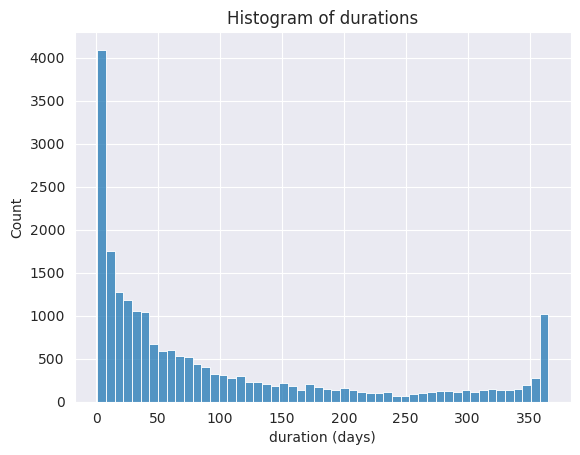

In [4]:
ax = sns.histplot(y["duration"], bins=52);
ax.set(
    title="Histogram of durations",
    xlabel="duration (days)",
);

**Question 1: Count the number of positive (and negative) events in `y`.**

*Hint: use the [.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method on `y["event"]`* 

In [37]:
y["event"].value_counts()

False    10809
True     10561
Name: event, dtype: int64

---

Let's further describe `y` with a Kaplan Meier:

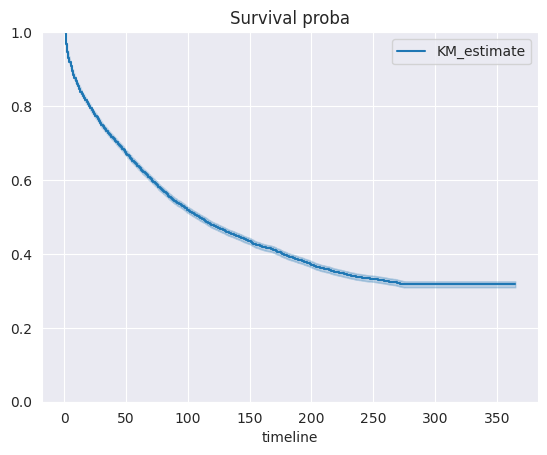

In [5]:
from lifelines import KaplanMeierFitter


km = KaplanMeierFitter()
km.fit(durations=y["duration"], event_observed=y["event"])
km.plot(title="Survival proba")
plt.ylim([0, 1]);

**Question 2: By looking at this graph, what is approximately the number of days for 50% of users to churn? What is the residual survival probability?** 

*Hint: Verify your approximation by printing the `median_survival_time_` attribute of km.*

In [38]:
km.median_survival_time_

107.0

---

Next, to start using our features `X`, we can run Kaplan Meier on a stratified feature of our choice. We need to concatenate X and y together first.

In [6]:
df = pd.concat([X, y], axis=1)
df.head()

,level,race,charclass,zone,guild,days_since_last_churn,days_since_first_start,number_of_previous_churn,event,duration
0,54,Orc,Hunter,Feralas,-1,0.0,0,0,True,87
1,60,Orc,Hunter,Thunder Bluff,-1,209.0,297,1,False,51
2,70,Orc,Hunter,The Barrens,79,0.0,0,0,True,180
3,29,Orc,Hunter,Undercity,-1,0.0,0,0,False,124
4,69,Orc,Rogue,Nagrand,-1,0.0,0,0,True,200


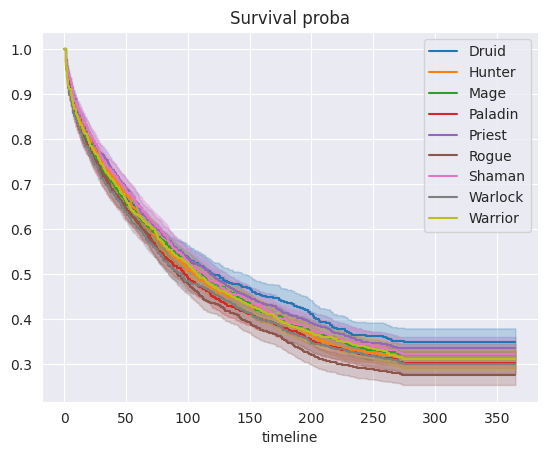

In [7]:
df = df.loc[df["charclass"] != "Death Knight"]

for charclass, df_charclass in df.groupby("charclass"):
    
    km = KaplanMeierFitter().fit(
        durations=df_charclass["duration"],
        event_observed=df_charclass["event"],
    )
    km.plot(
        title=f"Survival proba",
        label=charclass,
    );
plt.legend();

**Question 3: By looking at the graph above, which type of character looks to have the higher churn rate? What are the lower and higher median survival times (the durations when the survival proba is 50%)?**

In [ ]:
# By looking at the graph above, Rogue looks to have the higher churn rate.
# whene the survival proba is 50%, lower median survival times is 90 and higher median survival time is 140.

**Question 4: Run the stratified Kaplan Meier on the `race` feature instead of `charclass`, and find the category with the higher churn.**

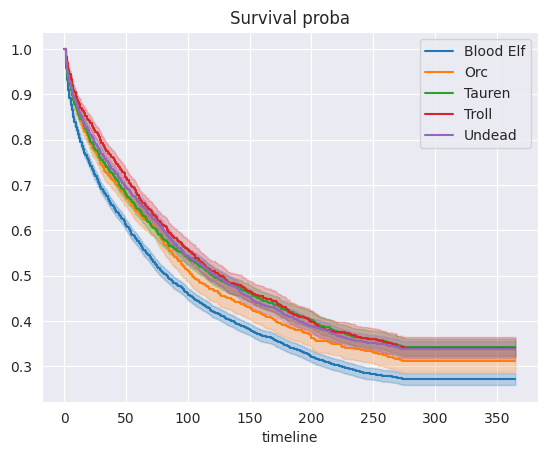

In [39]:
df = df.loc[df["race"] != "Death Knight"]

for race, df_race in df.groupby("race"):
    
    km = KaplanMeierFitter().fit(
        durations=df_race["duration"],
        event_observed=df_race["event"],
    )
    km.plot(
        title=f"Survival proba",
        label=race,
    );
plt.legend();
# the category with higher churn is Blood Elf.

---

We know split the dataset between the train set and test set, and create our time grid.

In [8]:
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0,
)
X_train.shape, X_test.shape

((5342, 8), (15755, 8))

In [9]:
def make_test_time_grid(y_train, n_steps):
    """Bound times to the range of duration."""
    # Some survival models can fail to predict near the boundary of the
    # range of durations observed on the training set.
    observed_duration = y_test.loc[y_test["event"] > 0]["duration"]
    
    # trim 1% of the span, 0.5% on each end:
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)


time_grid = make_test_time_grid(y_train, n_steps=100)
time_grid.shape

(100,)

Then, we define our Cox PH pipeline, using this time again the OneHotEncoder.

In [42]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from lifelines import CoxPHFitter

from utils import LifelinesWrapper


categ_cols = ["race", "charclass", "zone"]

ohe = OneHotEncoder(
    max_categories=10,
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
)

simple_transformer = make_column_transformer(
    (ohe, categ_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
cox_ph = LifelinesWrapper(CoxPHFitter(penalizer=1))

cox_ph = make_pipeline(
    simple_transformer,
    cox_ph,
)
cox_ph.fit(X_train, y_train)

/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10,
                                                                sparse_output=False),
                                                  ['race', 'charclass',
                                                   'zone'])],
                                   verbose_feature_names_out=False)),
                ('lifelineswrapper',
                 LifelinesWrapper(estimator=<lifelines.CoxPHFitter: fitted with 5342 total observations, 2707 right-censored observations>))])

,Model,IBS,C-index
0,Simple CoxPH,0.2044,0.6576


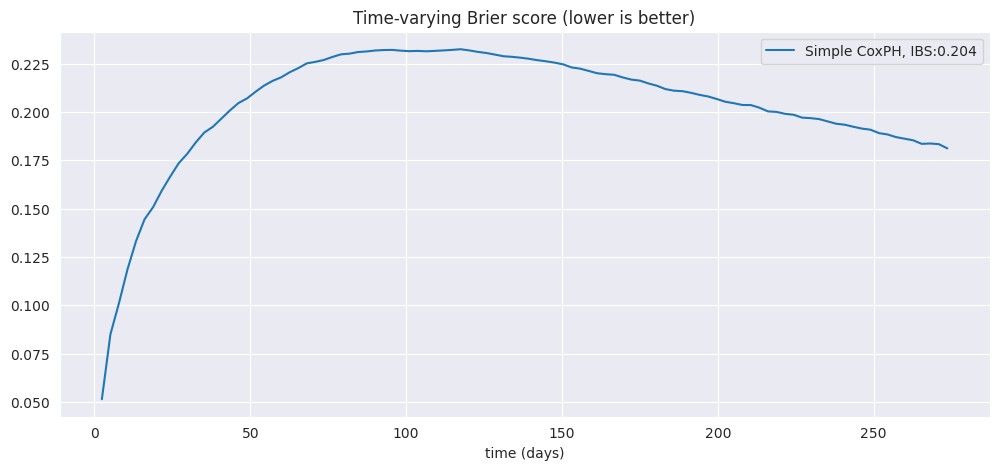

In [43]:
from utils import SurvivalAnalysisEvaluator

simple_cox_survival_probas = cox_ph.predict_survival_function(X_test, times=time_grid)

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator("Simple CoxPH", simple_cox_survival_probas)

**Question 5: The `penalizer` hyper-parameter of the Cox model controls the flexibility of the model (lower is more flexible). Replace it in the code above with `1` or `10`. Does it improve the performances of the model?**

In [ ]:
# Replace penalizer by 1 or 10 does not improve the performances of the models.
#penalizer=0.01, IBS=0.200
#penalizer=1, IBS=0.204
#penalizer=10, IBS=0.217


---

Let's now switch gears and try the Gradient Boosting Incidence from hazardous.

100%|██████████| 100/100 [00:04<00:00, 20.70it/s]


,Model,IBS,C-index
0,Simple CoxPH,0.2044,0.6576
1,Gradient Boosting Incidence,0.1965,0.6465


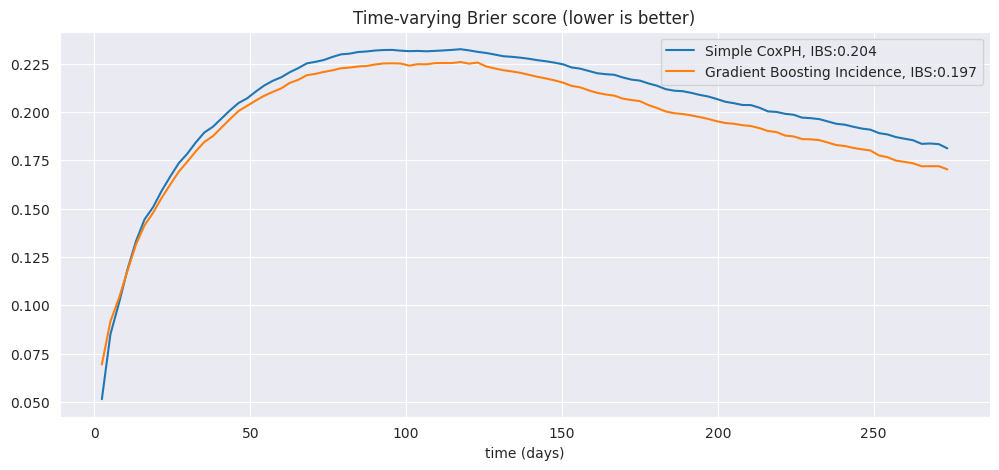

In [44]:
from hazardous.gradient_boosting_incidence import GradientBoostingIncidence

gb_incidence = make_pipeline(
    simple_transformer,
    GradientBoostingIncidence(n_iter=30, max_leaf_nodes=5, learning_rate=0.1),
)
gb_incidence.fit(X_train, y_train)
gb_incidence_survival_probas = gb_incidence.predict_survival_function(X_test, times=time_grid)

evaluator("Gradient Boosting Incidence", gb_incidence_survival_probas)

**Question 6: The `learning_rate` hyper-parameter is one of the most important. It represents how fast the Gradient Boosting Incidence update its weights. Change the value of the `learning_rate` (for exemple you can choose between: `10`, `0.1`, `0.01` and `0.00001`). <br>
Which value give better performance than the Cox?**

In [ ]:
# Learning_rate=0.1 give the better performance than Cox.
# with IBS=0.197 for the Gradient Boosting Incidence.
# with IBS=0.217 correspond to Cox.

---

To get a sense of the important features, we use a technique called `permutation_importance`. Broadly speaking, it compares the score (here the IBS) when we remove a column and keep the others.

**This can takes up to several minutes to run.**

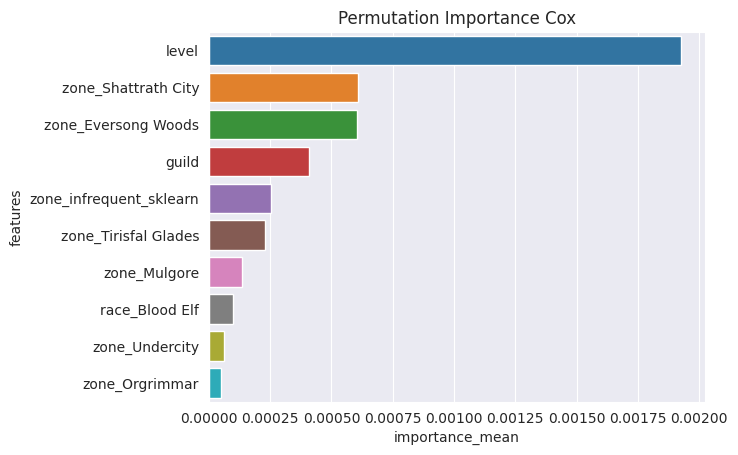

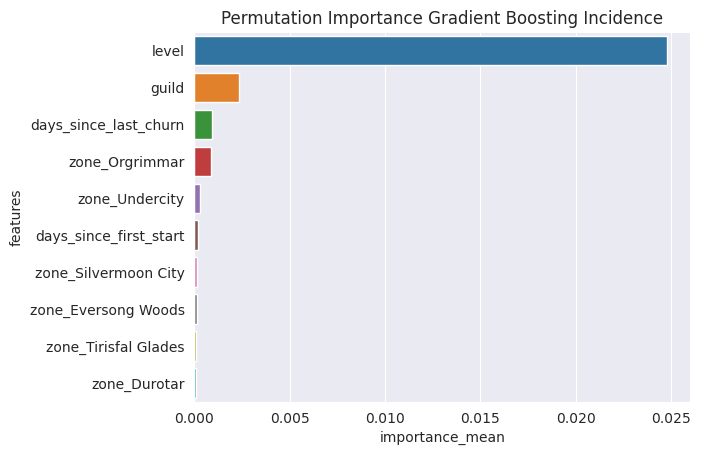

In [33]:
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

from hazardous.metrics import integrated_brier_score


# Define the custom score to be compatible with scikit-learn (here we reuse the IBS)
def ibs_scorer(estimator, X_test, y_test):
    surv_probas = estimator.predict_survival_function(X_test, times=time_grid)
    return -integrated_brier_score(y_train, y_test, surv_probas, time_grid)

# ignore this
gb_incidence[-1].set_params(show_progressbar=False)

# We map our model to some name for readability 
models = {
    "Cox": cox_ph,
    "Gradient Boosting Incidence": gb_incidence,
}

for name, model in models.items():
    # Separate the transformers from the estimator
    transformers, estimator = model[:-1], model[-1]
    
    # Get the feature importance
    results = permutation_importance(
        estimator,
        transformers.transform(X_test.iloc[:1000]),
        y_test.iloc[:1000],
        scoring=ibs_scorer,
        n_repeats=5,
    )

    # Create the result dataframe
    random_permutations = pd.DataFrame(
        dict(
            importance_mean=results.importances_mean,
            features=transformers.get_feature_names_out(),
        )
    ).sort_values("importance_mean", ascending=False).head(10)

    # Plot!
    fig, ax = plt.subplots()
    sns.barplot(
        y=random_permutations["features"],
        x=random_permutations["importance_mean"],
        orient="h",
        ax=ax,
    )
    ax.set(title=f"Permutation Importance {name}")

**Question 7: What seems to be the most important feature for both models?**

In [ ]:
# The most important feature for both models seems level.

Finally, we use another method called **Partial Dependence** to estimate the impact of some features on the churn probability. Here we only focus on the Gradient Boosting Incidence estimator.

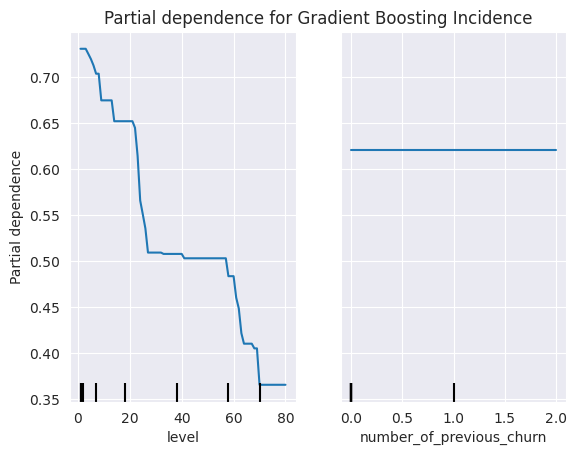

In [45]:
from sklearn.inspection import PartialDependenceDisplay

estimator = gb_incidence[-1]
estimator.set_params(time_horizon=150, show_progressbar=False)

transformers = gb_incidence[:-1]

disp = PartialDependenceDisplay.from_estimator(
    estimator,
    transformers.transform(X_test),
    response_method="predict_proba",
    features=["level", "number_of_previous_churn"],
    feature_names=transformers.get_feature_names_out(),
)
disp.bounding_ax_.set(title=f"Partial dependence for Gradient Boosting Incidence")
ax.set(ylim=[0, 1]);

**Question 8: These curves represent the probability of churn, when we increase the value of one feature. What conclusions can you make for these two features?** 

In [ ]:
# level incease seems to have a dramatic reduction on the churn probability.
# number_of_previous_churn increase seems have any effect on the churn probability.